In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from collections import deque
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import glob
import time
import cv2
import pickle
from moviepy.editor import VideoFileClip
%matplotlib inline


# Extract Features from Image

In [2]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features



In [3]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt = False,
                          visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt = False,
                          visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
def extract_features(imgs, cspace='RGB', spatial_size=(32,32),hist_bins=32, 
                     orient = 9,pix_per_cell = 8, cell_per_block = 2,
                     hog_channel = 0,spatial_features = True, 
                     histogram_features = True, hog_features = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        file_features = []
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        if spatial_features == True:
            spat_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spat_features)
        # Apply color_hist() also with a color space option now
        if histogram_features == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        # Apply hog_features
        if hog_features == True:
            if hog_channel == 'ALL':
                hog_feat = []
                for channel in range(feature_image.shape[2]):
                    hog_feat.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell,
                                                     cell_per_block, vis=False, feature_vec=True))
                
                hog_feat = np.ravel(hog_feat)
                
            else:
                hog_feat = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                            cell_per_block,vis=False, feature_vec=True)
            file_features.append(hog_feat)
                
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

8792 8968


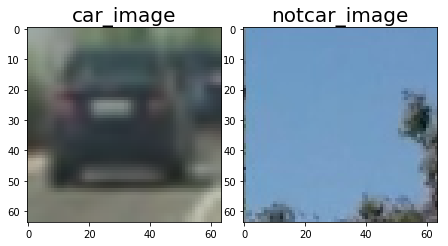

In [6]:

cars = glob.glob('./training_data/vehicles/**/*.png')
notcars = glob.glob('./training_data/non-vehicles/**/*.png')

        
car_image = mpimg.imread(cars[0])
notcar_image = mpimg.imread(notcars[0])

print(len(cars),len(notcars))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
fig.subplots_adjust(hspace = .2, wspace=.001)
ax1.imshow(car_image)
ax1.set_title('car_image', fontsize=20)
ax2.imshow(notcar_image)
ax2.set_title('notcar_image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

## Visualize HOG

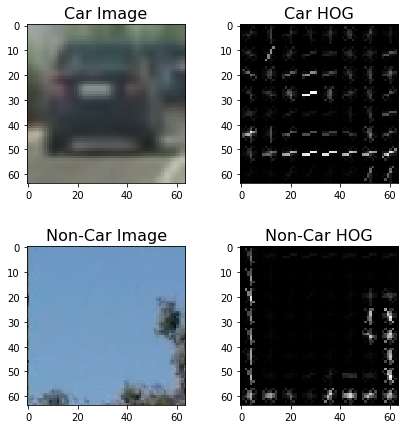

In [7]:

_,car_dst = get_hog_features(car_image[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
_,notcar_dst = get_hog_features(notcar_image[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
fig.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(notcar_image)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(notcar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

## Extract features from car and notcar images

In [8]:
colorspace = 'YUV'
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32
spatial_features = True
histogram_features = True
hog_features = True

t_start = time.time()

car_features = extract_features(cars, cspace=colorspace, spatial_size=spatial_size,hist_bins=hist_bins, 
                                orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
                                hog_channel = hog_channel,spatial_features = spatial_features, 
                                histogram_features = histogram_features, hog_features = hog_features)

notcar_features = extract_features(notcars, cspace=colorspace, spatial_size=spatial_size,hist_bins=hist_bins, 
                                   orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block,
                                   hog_channel = hog_channel,spatial_features = spatial_features, 
                                   histogram_features = histogram_features, hog_features = hog_features)

t_end = time.time()
print(t_end - t_start,'seconds to extract features')



72.09376645088196 seconds to extract features


In [9]:
x = np.vstack((car_features,notcar_features)).astype(np.float64)

x_scaler = StandardScaler().fit(x)
scaled_x = x_scaler.transform(x)


y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))

rand_state = np.random.randint(0,100)

#x_train,x_test,y_train,y_test = train_test_split(scaled_x,y,test_size = 0.2,random_state = rand_state)

x_train,x_test,y_train,y_test = train_test_split(scaled_x,y,test_size = 0.2,random_state = rand_state)
print(orient,'orientations,',pix_per_cell,'pixels per cell and',cell_per_block,'cells per block were used')
print('length of feature vector is',len(x_train))

11 orientations, 8 pixels per cell and 2 cells per block were used
length of feature vector is 14208


# Train the classifier

In [10]:
# use a linear svc
svc = LinearSVC()
svc.fit(x_train,y_train)
n_predict = 10
pred = svc.predict(x_test[0:n_predict])
#check the accuracy of svc
accuracy = svc.score(x_test,y_test)
print('svc predictions is',pred)
print('the accuracy of svc is',accuracy)

svc predictions is [ 0.  0.  1.  1.  1.  0.  1.  1.  1.  0.]
the accuracy of svc is 0.989583333333


# Detect vehicle with classifier in one image

In [11]:
def find_cars(img,ystart,ystop,scale,cspace,hog_channel,svc,x_scaler,orient,pix_per_cell,cell_per_block,
               spatial_size,hist_bins):
    
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_use = img[ystart:ystop,:,:]
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            color_trans = cv2.cvtColor(img_use, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            color_trans = cv2.cvtColor(img_use, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            color_trans = cv2.cvtColor(img_use, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            color_trans = cv2.cvtColor(img_use, cv2.COLOR_RGB2YUV)
    else:
        color_trans = np.copy(img_use)
        
    if scale != 1:
        imshape = color_trans.shape
        color_trans = cv2.resize(color_trans,(np.int(imshape[1]/scale),np.int(imshape[0]/scale)))
        
    if hog_channel == 'ALL':
        channel1 = color_trans[:,:,0]
        channel2 = color_trans[:,:,1]
        channel3 = color_trans[:,:,2]
    else:
        channel1 = color_trans[:,:,hog_channel]
        
    # define the blocks and steps
    nxblocks = (channel1.shape[1]//pix_per_cell) - cell_per_block + 1
    nyblocks = (channel1.shape[0]//pix_per_cell) - cell_per_block + 1
    nfeature_per_block = orient*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window//pix_per_cell) - cell_per_block + 1
    
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window)//cells_per_step
    nysteps = (nyblocks - nblocks_per_window)//cells_per_step
    
    hog1 = get_hog_features(channel1, orient, pix_per_cell, cell_per_block,vis = False,feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(channel2, orient, pix_per_cell, cell_per_block,vis = False,feature_vec=False)
        hog3 = get_hog_features(channel3, orient, pix_per_cell, cell_per_block,vis = False,feature_vec=False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            yposition = yb*cells_per_step
            xposition = xb*cells_per_step
            
            hog_feature1 = hog1[yposition:yposition + nblocks_per_window,xposition:xposition + nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feature2 = hog2[yposition:yposition + nblocks_per_window,xposition:xposition + 
                                    nblocks_per_window].ravel()
                hog_feature3 = hog3[yposition:yposition + nblocks_per_window,xposition:xposition + 
                                    nblocks_per_window].ravel()
                
                hog_features = np.hstack((hog_feature1,hog_feature2,hog_feature3))
                
            else:
                hog_features = hog_feature1
                
            
            xleft = xposition*pix_per_cell
            ytop = yposition*pix_per_cell
            
            test_features = []
            
            subimg = cv2.resize(color_trans[ytop:ytop + window,xleft:xleft + window],(64,64))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            test_stacked = np.hstack((spatial_features,hist_features,hog_features))
            test_reshaped = test_stacked.reshape(1, -1)
            test_features = x_scaler.transform(test_reshaped)
            test_prediction = svc.predict(test_features)
     

            #test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left,ytop_draw + ystart),(xbox_left + win_draw,ytop_draw + 
                                                                   win_draw + ystart)))
               
            
            
            
    return rectangles

    

In [12]:
test_img = mpimg.imread('./test_images/test1.jpg')


ystart = 400
ystop = 600
scale = 1.5
colorspace = 'YUV'
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32

rectangles = find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                        pix_per_cell,cell_per_block,spatial_size,hist_bins)
            
print(len(rectangles),'rectangles found in image')        

9 rectangles found in image


## draw rectangles on one image

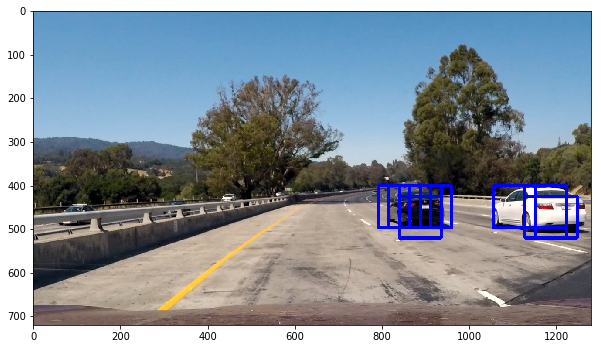

In [13]:
def draw_boxes(img,bboxes,color = (0,0,255), thick = 6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for box in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy,box[0],box[1],color,thick)
    # Return the image copy with boxes drawn
    return imcopy

test_image_rects = draw_boxes(test_img,rectangles)
plt.figure(figsize = (10,10))
plt.imshow(test_image_rects)

The number of rectangles are 0


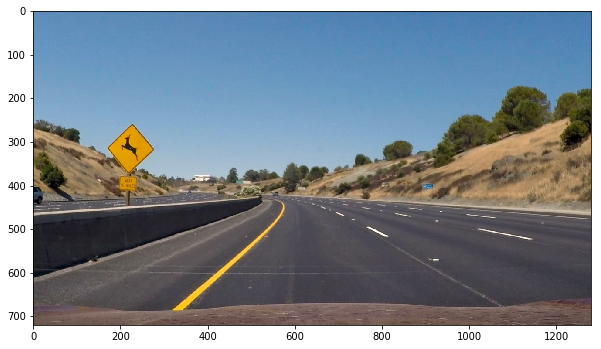

In [14]:
test_img = mpimg.imread('./test_images/test2.jpg')

rects = []

colorspace = 'YUV'
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32

ystart = 500
ystop = 600
scale = 1.5
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))

rectangles = [item for sublist in rects for item in sublist]
test_img_rects = draw_boxes(test_img,rectangles,color = 'random',thick = 2)
plt.figure(figsize = (10,10))
plt.imshow(test_img_rects)
print('The number of rectangles are',len(rectangles))

The number of rectangles are 1


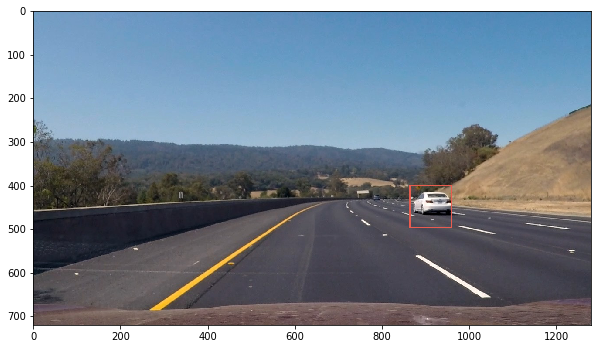

In [15]:
test_img = mpimg.imread('./test_images/test3.jpg')

rects = []

colorspace = 'YUV'
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32

ystart = 400
ystop = 600
scale = 1.5
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))

rectangles = [item for sublist in rects for item in sublist]
test_img_rects = draw_boxes(test_img,rectangles,color = 'random',thick = 2)
plt.figure(figsize = (10,10))
plt.imshow(test_img_rects)
print('The number of rectangles are',len(rectangles))

The number of rectangles are 14


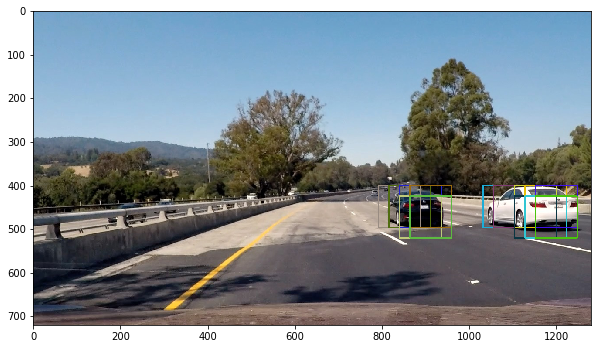

In [16]:
test_img = mpimg.imread('./test_images/test4.jpg')

rects = []

colorspace = 'YUV'
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32

ystart = 400
ystop = 600
scale = 1.5
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))

rectangles = [item for sublist in rects for item in sublist]
test_img_rects = draw_boxes(test_img,rectangles,color = 'random',thick = 2)
plt.figure(figsize = (10,10))
plt.imshow(test_img_rects)
print('The number of rectangles are',len(rectangles))

The number of rectangles are 3


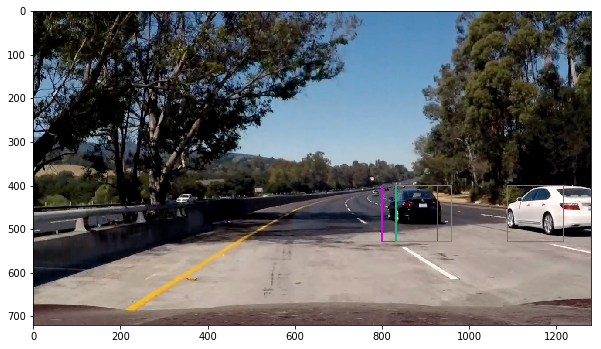

In [17]:
test_img = mpimg.imread('./test_images/test5.jpg')

rects = []

colorspace = 'YUV'
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32

ystart = 400
ystop = 600
scale = 2.0
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))

rectangles = [item for sublist in rects for item in sublist]
test_img_rects = draw_boxes(test_img,rectangles,color = 'random',thick = 2)
plt.figure(figsize = (10,10))
plt.imshow(test_img_rects)
print('The number of rectangles are',len(rectangles))

The number of rectangles are 4


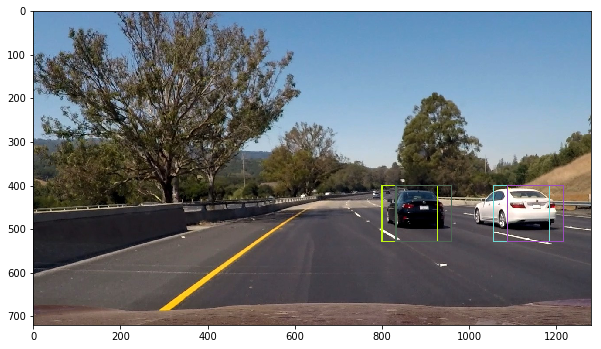

In [18]:
test_img = mpimg.imread('./test_images/test6.jpg')

rects = []

colorspace = 'YUV'
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32

ystart = 400
ystop = 600
scale = 2.0
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))

rectangles = [item for sublist in rects for item in sublist]
test_img_rects = draw_boxes(test_img,rectangles,color = 'random',thick = 2)
plt.figure(figsize = (10,10))
plt.imshow(test_img_rects)
print('The number of rectangles are',len(rectangles))

## Multiple scale windows

The number of rectangles are 7


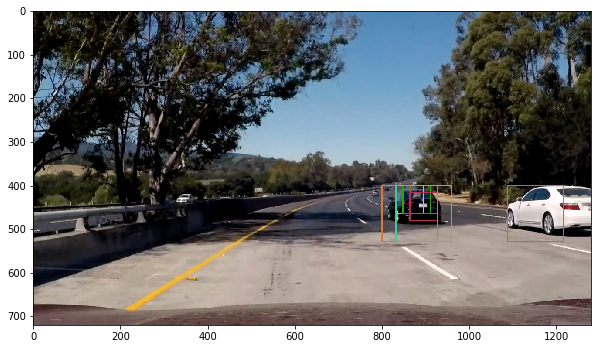

In [56]:
test_img = mpimg.imread('./test_images/test5.jpg')

rects = []

colorspace = 'YUV'
orient = 11
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32,32)
hist_bins = 32

ystart = 400
ystop = 600
scale = 1.0
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))

ystart = 400
ystop = 500
scale = 1.5
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))


ystart = 416
ystop = 480
scale = 1.5
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))
ystart = 450
ystop = 560
scale = 1.5
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))

ystart = 450
ystop = 528
scale = 1.5
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))

ystart = 400
ystop = 528
scale = 2.0
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))

ystart = 432
ystop = 560
scale = 2.0
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))

ystart = 400
ystop = 600
scale = 2.0
rects.append(find_cars(test_img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                            pix_per_cell,cell_per_block,spatial_size,hist_bins))
                            


rectangles = [item for sublist in rects for item in sublist]
test_img_rects = draw_boxes(test_img,rectangles,color = 'random',thick = 2)
plt.figure(figsize = (10,10))
plt.imshow(test_img_rects)
print('The number of rectangles are',len(rectangles))

## Heat Map

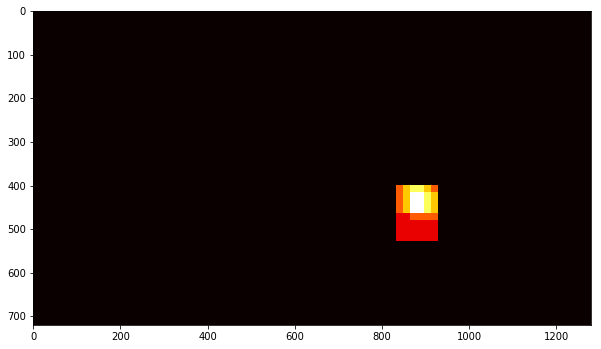

In [57]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heat_map = np.zeros_like(test_img[:,:,0])
heat_map = apply_threshold(add_heat(heat_map,rectangles),1)
plt.figure(figsize = (10,10))
plt.imshow(heat_map,cmap = 'hot')


1 cars found


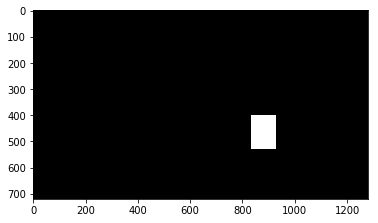

In [58]:

labels = label(heat_map)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

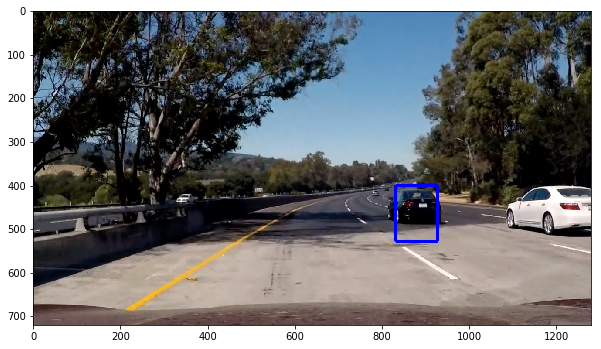

In [59]:

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img,rects
        
# Draw bounding boxes on a copy of the image
draw_img,rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize = (10,10))
plt.imshow(draw_img)        

In [60]:
def process_image(img):
    
    rects = []

    colorspace = 'YUV'
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_size = (32,32)
    hist_bins = 32

    ystart = 400
    ystop = 464
    scale = 1.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))


    ystart = 416
    ystop = 480
    scale = 1.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))
    ystart = 400
    ystop = 528
    scale = 1.5
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))

    ystart = 400
    ystop = 528
    scale = 2.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))

    ystart = 400
    ystop = 560
    scale = 2.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))

    ystart = 400
    ystop = 600
    scale = 2.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))

    ystart = 400
    ystop = 600
    scale = 1.5
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))


    rectangles = [item for sublist in rects for item in sublist]
    
    
    heat_map = np.zeros_like(img[:,:,0])
    heat_map = apply_threshold(add_heat(heat_map,rectangles),1)
    
    labels = label(heat_map)
    draw_img,rect = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

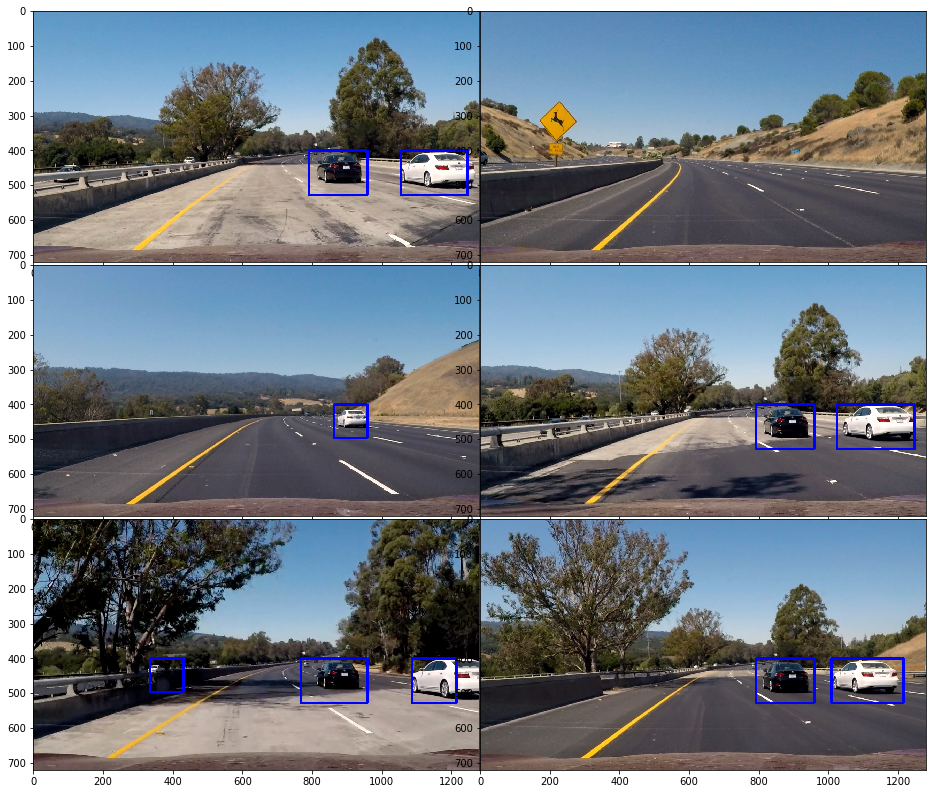

In [61]:
images = glob.glob('./test_images/test*.jpg')
prev_rectangles = deque(maxlen = 8)
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(images):
    
    img = mpimg.imread(im)
    draw_img = process_image(img)
    axs[i].imshow(draw_img)

# Pipeline for video

In [66]:
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]


In [26]:
def process_video(img):
    
    rects = []

    colorspace = 'YUV'
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_size = (32,32)
    hist_bins = 32

    ystart = 400
    ystop = 464
    scale = 1.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))


    ystart = 416
    ystop = 480
    scale = 1.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))
    ystart = 400
    ystop = 528
    scale = 1.5
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))

    ystart = 400
    ystop = 528
    scale = 2.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))

    ystart = 400
    ystop = 560
    scale = 2.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))

    ystart = 400
    ystop = 600
    scale = 2.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))

    ystart = 400
    ystop = 600
    scale = 1.5
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))



    rectangles = [item for sublist in rects for item in sublist]
    
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heat_map = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heat_map = add_heat(heat_map,rect_set)
    
    heat_map = apply_threshold(heat_map,1)
    
    labels = label(heat_map)
    draw_img,rect = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [27]:
det = Vehicle_Detect()

test_output_video = 'test_video_output.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_output = clip_test.fl_image(process_video)
%time clip_test_output.write_videofile(test_output_video,audio = False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:28<00:00,  1.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 29.6 s


In [28]:
det = Vehicle_Detect()

project_output_video = 'project_video_output.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_output = clip_test.fl_image(process_video)
%time clip_test_output.write_videofile(project_output_video,audio = False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [16:17<00:00,  1.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 16min 18s


In [67]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


def undistort(img):

    undist = cv2.undistort(img,mtx,dist,None,mtx)
    
    return undist

def hls_sthresh(img,thresh = (220,255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    hls_s = hls[:,:,2]*(255/np.max(hls[:,:,2]))
    
    binary_output = np.zeros_like(hls_s)
    binary_output[(hls_s > thresh[0])&(hls_s <= thresh[1])] = 1
    
    return binary_output

def hls_lthresh(img,thresh = (220,255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the L channel
    hls_l = hls[:,:,1]*(255/np.max(hls[:,:,1]))
    
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0])&(hls_l <= thresh[1])] = 1
    
    return binary_output

def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def pipeline(img):
    
    # undistort image
    undist = undistort(img)
    
    # perspective transform the image
    height,weight = undist.shape[:2]
    src = np.float32([(575,464),(707,464),(258,682),(1049,682)])
    dst = np.float32([(450,0),(weight - 450,0),(450,height),(weight - 450,height)])
    
    M = cv2.getPerspectiveTransform(src,dst)
    M_inv = cv2.getPerspectiveTransform(dst,src)
    unwarp = cv2.warpPerspective(undist,M,(weight,height),flags = cv2.INTER_LINEAR)
    
    # HLS L-channel Threshold
    HSL_L = hls_lthresh(unwarp,thresh = (220,255))
    
    # Lab B-channel Threshold
    LAB_B = lab_bthresh(unwarp, thresh=(190,255))
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(HSL_L)

    combined[(HSL_L == 1) | (LAB_B == 1)] = 1
    
    return undist, combined, M_inv

def lane_locating(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:],axis = 0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.uint8(np.dstack((binary_warped,binary_warped,binary_warped))*255)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarterpoint = np.int(midpoint//2)
    
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarterpoint:midpoint]) + quarterpoint
    rightx_base = np.argmax(histogram[midpoint:quarterpoint + midpoint]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Rectangle data for visualization
    rectangle_data = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        rectangle_data.append((win_y_low,win_y_high,win_xleft_low,win_xleft_high,win_xright_low,win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low)&(nonzeroy < win_y_high)&(nonzerox >= win_xleft_low)&(nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low)&(nonzeroy < win_y_high)&(nonzerox >= win_xright_low)&(nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit,right_fit = (None,None)
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty,leftx,2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty,rightx,2)
    
    visualization_data = (rectangle_data,histogram)

    return out_img,left_fit,right_fit,left_lane_inds,right_lane_inds,visualization_data

def window_search(left_fit, right_fit, binary_warped):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 80
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))&(nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))&(nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    
    left_fit_new,right_fit_new = (None,None)
    
    if len(leftx)!= 0:
        left_fit_new = np.polyfit(lefty,leftx,2)
    if len(rightx)!= 0:
        right_fit_new = np.polyfit(righty,rightx,2)
    
    return left_fit_new,right_fit_new,left_lane_inds,right_lane_inds

def drawing(img,img_bin,left_fit,right_fit,M_inv):
    
    new_img = np.copy(img)
    
    if left_fit is None or right_fit is None:
        return img
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_bin).astype(np.uint8)
    color_warp = np.dstack((warp_zero,warp_zero,warp_zero))
    
    height,weight = img_bin.shape
    ploty = np.linspace(0,height - 1,num = height) # to cover the same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    pts = np.hstack((pts_left,pts_right))
    
    # draw the lane onto the warped blank image
    cv2.fillPoly(color_warp,np.int_([pts]),(0,255,0))
    cv2.polylines(color_warp,np.int32([pts_left]),isClosed = False, color = (255,0,255), thickness = 15)
    cv2.polylines(color_warp,np.int32([pts_right]),isClosed = False, color = (255,0,255), thickness = 15)
    
    #warp the blank back to original image space using inverse perspective matrix (M_inv)
    newwarp = cv2.warpPerspective(color_warp,M_inv,(weight,height))
    result = cv2.addWeighted(new_img,1,newwarp,0.5,0)
    
    return result

def curvature(img_bin,left_fit,right_fit,left_lane_inds,right_lane_inds):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720
    xm_per_pix = 3.7/378
    left_curverad,right_curverad,center_dist = (0,0,0)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = img_bin.shape[0]
    ploty = np.linspace(0,h - 1,h)
    y_eval = np.max(ploty)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx)!= 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
        right_fit_cr = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if right_fit is not None and left_fit is not None:
        car_position = img_bin.shape[1]/2
        left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (right_fit_x_int + left_fit_x_int)/2
        center_dist = (car_position - lane_center_position)*xm_per_pix
    return left_curverad,right_curverad,center_dist

def draw_lane_and_data(img,curverad,center_dist):
    new_image = np.copy(img)
    h = new_image.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    test = 'Curve radius:' + '{:04.2f}'.format(curverad) + 'm'
    cv2.putText(new_image,test,(40,70),font,1.5,(200,255,155),2,cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    
    abs_center_dist = abs(center_dist)
    test = '{:04.2f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_image,test,(40,120),font,1.5,(200,255,155),2,cv2.LINE_AA)
    return new_image


def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img

In [68]:
def process_image_lane_and_find_car(img):
    
    rects = []

    colorspace = 'YUV'
    orient = 11
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    spatial_size = (32,32)
    hist_bins = 32

    ystart = 400
    ystop = 464
    scale = 1.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))


    ystart = 416
    ystop = 480
    scale = 1.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))
    ystart = 432
    ystop = 528
    scale = 1.5
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))

    ystart = 400
    ystop = 528
    scale = 2.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))

    ystart = 432
    ystop = 560
    scale = 2.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))

    ystart = 400
    ystop = 600
    scale = 2.0
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))

    ystart = 400
    ystop = 600
    scale = 1.5
    rects.append(find_cars(img,ystart,ystop,scale,colorspace,hog_channel,svc,x_scaler,orient,
                                pix_per_cell,cell_per_block,spatial_size,hist_bins))



    rectangles = [item for sublist in rects for item in sublist]
                                
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heat_map = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heat_map = add_heat(heat_map,rect_set)
    
    heat_map = apply_threshold(heat_map,1)
    labels = label(heat_map)
    draw_img,rect = draw_labeled_bboxes(np.copy(img), labels)
  
    # draw the lane line
    new_img = np.copy(draw_img)
    undist,img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not left_line.detected or not right_line.detected:
        out_img,left_fit, right_fit, left_lane_inds, right_lane_inds,visualization_data = lane_locating(img_bin)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = window_search(left_line.best_fit, right_line.best_fit,img_bin)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if left_fit is not None and right_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        height = draw_img.shape[0]
        left_fit_x_int = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
        right_fit_x_int = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
        x_int_diff = abs(right_fit_x_int - left_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            left_fit = None
            right_fit = None
            
    left_line.add_fit(left_fit, left_lane_inds)
    right_line.add_fit(right_fit, right_lane_inds)
    
    # draw the current best fit if it exists
    if left_line.best_fit is not None and right_line.best_fit is not None:
        img_out1 = drawing(undist, img_bin, left_line.best_fit, right_line.best_fit, Minv)
        rad_left, rad_right, d_center = curvature(img_bin, left_line.best_fit, right_line.best_fit,left_lane_inds, right_lane_inds)
        img_out = draw_lane_and_data(img_out1, (rad_left+rad_right)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(left_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(right_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, left_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, right_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if left_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(left_fit[0]) + ' {:0.6f}'.format(left_fit[1]) + ' {:0.6f}'.format(left_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if right_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(right_fit[0]) + ' {:0.6f}'.format(right_fit[1]) + ' {:0.6f}'.format(right_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(left_line.best_fit[0]) + ' {:0.6f}'.format(left_line.best_fit[1]) + ' {:0.6f}'.format(left_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(right_line.best_fit[0]) + ' {:0.6f}'.format(right_line.best_fit[1]) + ' {:0.6f}'.format(right_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(left_line.diffs[0]) + ' {:0.6f}'.format(left_line.diffs[1]) + ' {:0.6f}'.format(left_line.diffs[2])
        if left_line.diffs[0] > 0.001 or left_line.diffs[1] > 1.0 or left_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(right_line.diffs[0]) + ' {:0.6f}'.format(right_line.diffs[1]) + ' {:0.6f}'.format(right_line.diffs[2])
        if right_line.diffs[0] > 0.001 or right_line.diffs[1] > 1.0 or right_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(left_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(right_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
        
    
    
    return img_out

In [69]:
calibration = pickle.load(open( "calibration_file.p", "rb" ))
mtx = calibration['mtx']
dist = calibration['dist']
det = Vehicle_Detect()
left_line = Line()
right_line = Line()
project_output_video_with_lane_line = 'project_video_output_with_lane_line.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_output = clip_test.fl_image(process_image_lane_and_find_car)
%time clip_test_output.write_videofile(project_output_video_with_lane_line,audio = False)

[MoviePy] >>>> Building video project_video_output_with_lane_line.mp4
[MoviePy] Writing video project_video_output_with_lane_line.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [22:02<00:02,  2.25s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_with_lane_line.mp4 

Wall time: 22min 5s
